# 1) Çalışmanın Özeti

Bu çalışmada, çelik yüzeyindeki kusurların sınıflandırılması yapılmıştır.. Çalışmanın özeti şöyledir:

-Veri setinin yüklenmesi

-Sınıf etiketlerinin tek bir sütünda toplanması ve görselleştirme

-Destek Vektör Makineleri ve Rasgele Orman sınıflandırıcılarının en iyi parametre seçimi

-Sonuçların karışıklık matrisi ve sınıflandırma raporu ile verilmesi


In [4]:
#Gerekli Kütüphanelerin İmport Edilmesi

import numpy as np # linear cebir işleri için
import pandas as pd # Veri işlemek için

#Görselleştirme - Grafik
import matplotlib.pyplot as plt
import seaborn as sns

#Makine Öğrenmesi 
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split, GridSearchCV

#Sistem 
import os
import warnings

#Uyarıları kapatmak için 
warnings.filterwarnings('ignore')
print(os.listdir("../celik_kusurlarinin_siniflandirilmasi/veri"))

['faults.csv']


# 2) Veri Seti Hakkında Kavramsal Değerlendirme

Bu veri seti, Semeion, İletişim Bilimleri Araştırma Merkezi tarafından yapılan araştırmalardan elde edilmiştir.. Araştırmanın asıl amacı, paslanmaz çelik plakalardaki yüzey kusurlarının tipini altı tip olası kusur (artı “diğer”) ile doğru bir şekilde sınıflandırmaktı. Özellik vektörü, kusurun geometrik şeklini ve taslağını yaklaşık olarak tanımlayan 27 özellikten oluşturulmuştur. Araştırma öyküsüne göre, Semeion bu görev için Centro Sviluppo Materiali (İtalya) kurumu tarafından görevlendirilmiştir ve bu nedenle özellik vektörleri olarak kullanılan 27 özelliğin niteliği veya 6 sınıf kusur tipi hakkında ayrıntılı bilgi vermek mümkün değildir.

-Veri setinde 34 özellik vardır. İlk 27 özellik, görüntülerde görülen bir çeşit çelik levha hatasını içerir. Son 7 sütun, kodlanmış sınıflardır, yani plaka arızası "Stains" olarak sınıflandırılırsa, o sütunda 1 ve diğer sütunlarda 0 olur. Yani son 7 sınıf özellik vektörünün etiketidir. Son yedi özellik şöyledir; Pastry Z_Scratch K_Scatch Stains Dirtiness Bumps Other_Faults

In [6]:
#Veri setinin yüklenmesi
dataset_temp=pd.read_csv("../celik_kusurlarinin_siniflandirilmasi/veri/faults.csv")

#Veri setine ait özet bilgiler 
dataset_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
X_Minimum                1941 non-null int64
X_Maximum                1941 non-null int64
Y_Minimum                1941 non-null int64
Y_Maximum                1941 non-null int64
Pixels_Areas             1941 non-null int64
X_Perimeter              1941 non-null int64
Y_Perimeter              1941 non-null int64
Sum_of_Luminosity        1941 non-null int64
Minimum_of_Luminosity    1941 non-null int64
Maximum_of_Luminosity    1941 non-null int64
Length_of_Conveyer       1941 non-null int64
TypeOfSteel_A300         1941 non-null int64
TypeOfSteel_A400         1941 non-null int64
Steel_Plate_Thickness    1941 non-null int64
Edges_Index              1941 non-null float64
Empty_Index              1941 non-null float64
Square_Index             1941 non-null float64
Outside_X_Index          1941 non-null float64
Edges_X_Index            1941 non-null float64
Edges_Y_Index            194

# 3) Veri Seti Hakkında Teknik Değerlendirme

Yukarıda yer alan bilglere bakarak veri seti hakkında şunları söylebiliriz:

-Veri seti 1941 örnekten oluşuyor.

-Eksik veri yok.

-Tüm veriler sayısaldır.(int ve float)

-Son yedi sütun etiket sütunlarıdır.

In [9]:
#Veri setine ait ilk 5 gözlem
dataset_temp.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


# 4) Kusur Sütunlarının Tek Sütunda Toplanması

'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps' ve 'Other_Faults' sütunları, örneğe ait etiketleri tutmaktadır. Bu etiket sütunlarını 'target' sütunu altında toplayalım (Tahmini yapabilmek için)

In [10]:
#Kusur sınıfını gösteren sütünlar (son 7 sutun)
label_columns=dataset_temp.columns.values[-7:]

#Kusur sınıfını gösteren sütünlar 'target' sütünu altında toplanıyor
#axis = 1 satır işlemi yapmak için axis = 0 sütün işlemi yapmak için kullanılır.
# idxmax, Maksimum değerin satır etiketini döndürür.
targets=(dataset_temp.iloc[:,-7:]==1).idxmax(1) 

#Kusur sınıfını gösteren sütünlar veri setinden çıkartılır
dataset=dataset_temp.drop(label_columns,axis=1)

#Oluşturulan target sınıfı veri setine ekleniyor
dataset['target']=targets
print("Kusur sütunları tek sütunda toplandı")


Kusur sütunları tek sütunda toplandı


# 5) Veri Setine Genel Bakış

Veri seti hakkında aşağıdaki bilgilere bakalım;

-Veri Setinin Boyutu

-Veri Setindeki Bir Kaç Satır

-Veri Setindeki Tüm Özelliklerin İstatiksel Özeti

-Sınıf Değişkeninin Veriler Üzerindeki Dağılımı

In [11]:
# 5.1) Veri setinin boyutu
"""Veri setinde kaç örnek(satır) olduğu ve örneklerin özellik(sütun) sayılarını pandas DataFrame 
nesnesinin shape özlliğiyle öğrenebiliriz."""

dataset.shape

(1941, 28)

In [12]:
# 5.2) Veri setindeki bir kaç satır
"""Veri setindeki değerleri doğrudan incelemek her zaman faydalıdır. Bunun için pandas DataFrame nesnesinin
head() fonksiyonundan faydalanacağız. head() fonksiyonu parametre olarak listelenecek satır sayısını alır ve birinci 
satırdan itibaren listeler. Varsayılan olarak listelenecek satır sayısı 5'tir;head(n=5)"""

dataset.head(n=4)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,target
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,Pastry
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,Pastry
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,Pastry
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,Pastry


In [13]:
# 5.3) Veri setindeki tüm özelliklerin istatistiksel özeti
"""Veri setindeki özelliklerin, istatiksel özeti Tanımlayıcı İstatistik(Descriptive Statistics) olarak tanımlanır. 
Tanımlayıcı istatistik veri setinin özetini ve analizini istatiksel hesaplamalarla ortaya koymayı amaçlar. 
Kullanılan temel hesaplamalarla; ortalama, standart sapma, mod, min, max, baslıklık ve eğrilik değerleri elde edilir.

Tanımlayıcı istatiksel bilgileri elde etmek için pandas DataFrame nesnesinin describe() fonksiyonunu kullanacağız. 
describe() fonksiyonu sayısal(float int) özellikler için; count, mean, std, min, max ve yüzdelik değerlere 
nesne(string, timestamp) verileri için count, unique, top, ve freq değerlere döner."""

describe=dataset.describe().T

"""
describe fonksiyonu yamukluk(skew) ve basıklık(kurtosis) değerlerini
vermediği için kendimiz ekliyoruz
"""
describe['skew']=dataset.skew().values
describe['kurtosis']=dataset.kurt().values
describe=round(describe, 2)
describe

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
X_Minimum,1941.0,571.14,520.69,0.00,51.00,435.00,1053.00,1705.00,0.50,-1.15
X_Maximum,1941.0,617.96,497.63,4.00,192.00,467.00,1072.00,1713.00,0.52,-1.08
Y_Minimum,1941.0,1650684.87,1774578.41,6712.00,471253.00,1204128.00,2183073.00,12987661.00,2.81,11.36
Y_Maximum,1941.0,1650738.71,1774590.09,6724.00,471281.00,1204136.00,2183084.00,12987692.00,2.81,11.36
Pixels_Areas,1941.0,1893.88,5168.46,2.00,84.00,174.00,822.00,152655.00,14.08,375.84
X_Perimeter,1941.0,111.86,301.21,2.00,15.00,26.00,84.00,10449.00,21.54,715.96
Y_Perimeter,1941.0,82.97,426.48,1.00,13.00,25.00,83.00,18152.00,39.29,1663.05
Sum_of_Luminosity,1941.0,206312.15,512293.59,250.00,9522.00,19202.00,83011.00,11591414.00,7.73,131.50
Minimum_of_Luminosity,1941.0,84.55,32.13,0.00,63.00,90.00,106.00,203.00,-0.11,0.11
Maximum_of_Luminosity,1941.0,130.19,18.69,37.00,124.00,127.00,140.00,253.00,1.29,7.86


In [14]:
"""Yukarıdaki tabloda veri setinde sayısal değer içeren tüm özelliklerin tanımlayıcı istatiksel bilgileri yer almaktadır. 
'target' özelliği string değer içerdiği için tanımlayıcı istatiksel bilgileri yoktur. 'target' özelliğinin 
tanımlayıcı istatiksel bilgilerini ayrıca elde etmemiz gerekiyor."""

dataset['target'].describe()

count             1941
unique               7
top       Other_Faults
freq               673
Name: target, dtype: object

In [16]:
# 5.4) Sınıf dağılımları
# Veri setindeki çıktı(target) değişkeninin dağılımına bakalım.

print(dataset['target'].value_counts())

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: target, dtype: int64


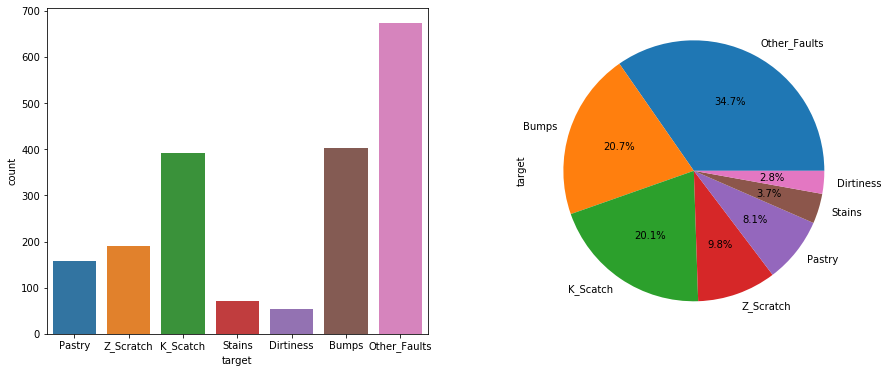

In [17]:
#Sınıflara ait örnek sayılarının grafikle gösterimi 
fig, ax=plt.subplots(1,2,figsize=(15,6))
sns.countplot(x='target', data=dataset, ax=ax[0])
dataset['target'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])

Bazı sınıfları diğer sınıflardan çok fazla örnek içeren veri setleri dengesiz dağılımlı(Imbalanced) veri setleri olarak adlandırılır. Dengesiz veri setleri üzerinde çalışırken daha kararlı sonuçlar elde etmek için dikkatli olmak gerekir.

Yukarıdaki grafiklerde dengesiz bir sınıf dağılımı görünüyor. Veri setini eğitim ve test olarak ayrıştırdığımızda bu duruma dikkate etmemiz gerekiyor. Bunun için train_test_split fonksiyonunun stratify parametresini stratify=target olarak atamamız gerekir. Bu şekilde sınıflar eşit oranda eğitim ve test için ayrılacaktır.

# 6) Verilerin Grafiklerle İncelenmesi

Bir üst bölümde veri setinin tanımlayıcı istatiksel özet tablosunu elde etmiştik. İstatiksel özet tablosu veri seti hakkında çok fazla bilgi verse de bu bilgilerin herkes tarafından anlaşılması zordur. Verilerin grafiklerle incelenmesi verilerin yorumlanmasında önemli katkı sağlar.

Verilerin incelenmesi için kullanılabilecek grafikler türleri üçe ayrılır:

-Tek Değişken Dağılımı(Univariate Distribution) Grafikler

-İki Değişken Dağılımı (Bivariate Distribution) Grafikler

-Çoklu Değişken Dağılımı (Multivariate Distribution) Grafikler


### Tek Değişken Grafikler

Tek değişken dağılımı için kullanılabilecek grafik türleri:

-Histogram

-Kernel Density Estimation

-Kutu Grafiği(BoxPlot)

##### Histogram
Histogram grafiği belirli aralıktaki değerlerin sıklığını kutularlar(bins) gösteren grafik türüdür. Bir özelliğin histogram grafiğine bakarak veri dağılımının normal(Gaussian), üstel, bimodal, yamuk(skewed) gibi karakteristiğini anlamaya olanak sağlar.

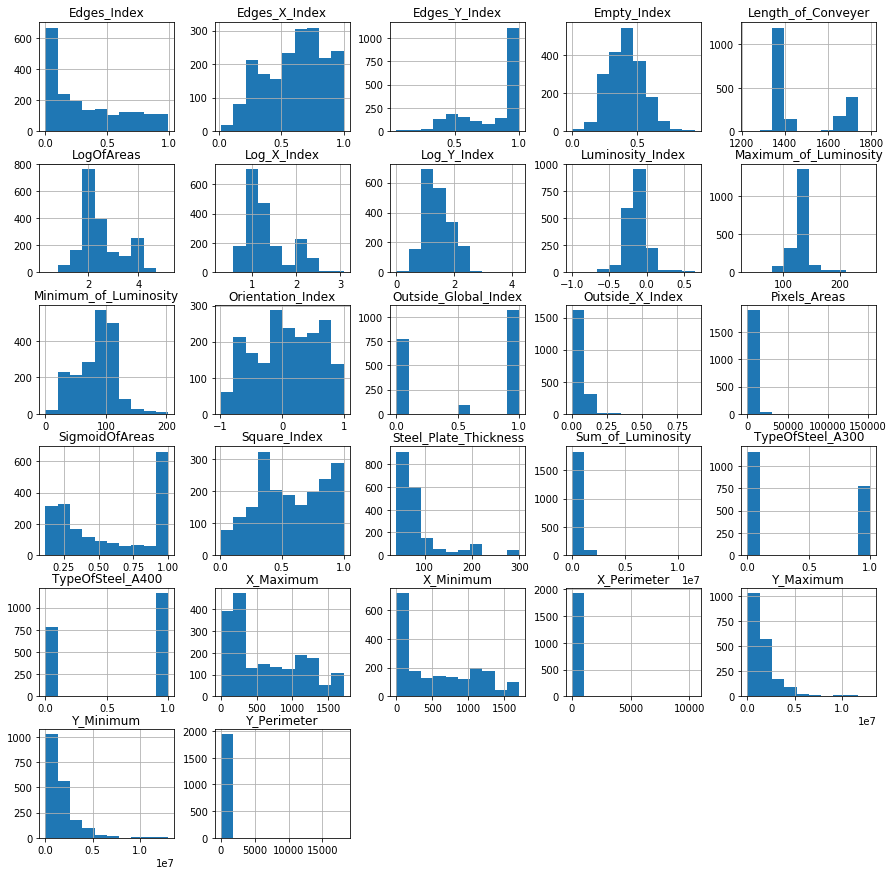

In [18]:
dataset.hist(figsize=(15,15))
plt.show()

Yukarıdaki histogram graklerine göre dağılım karakteristiği belirgin özellikler:

Normal: Empty_Index, Luminosity_Index

Yamuk: Log_X_Index, Log_Y_Index

Üstel: 'Edges_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Steel_Plate_Thickness', 'X_Maximum', 'X_Minimum', 'Y_Maximum', 'Y_Minimum',

Bimodal: 'Length_of_Conveyer', 'Outside_Global_Index', 'TypeOfSteel_A300', 'TypeOfSteel_A400'

##### Kernel Density Estimation(Çekirdek Yoğunluk Kestirimi)

KDE grafiği özelliğe ait verilen dağılımı gösteren tek değişken dağılım grafiğidir. Histogram grafiğindeki kutuların üst kısımlarının birbirine çizgiyle birleştirilmesiyle olşturulur. İnsan gözünün yorumlamasına daha elverişlidir. Histogram grafiği gibi, belki daha iyi, verinin normal(Gaussian), üstel, bimodal(iki tepeli), yamuk(skewed) dağılım karakteristiğini anlamaya olanak sağlar.

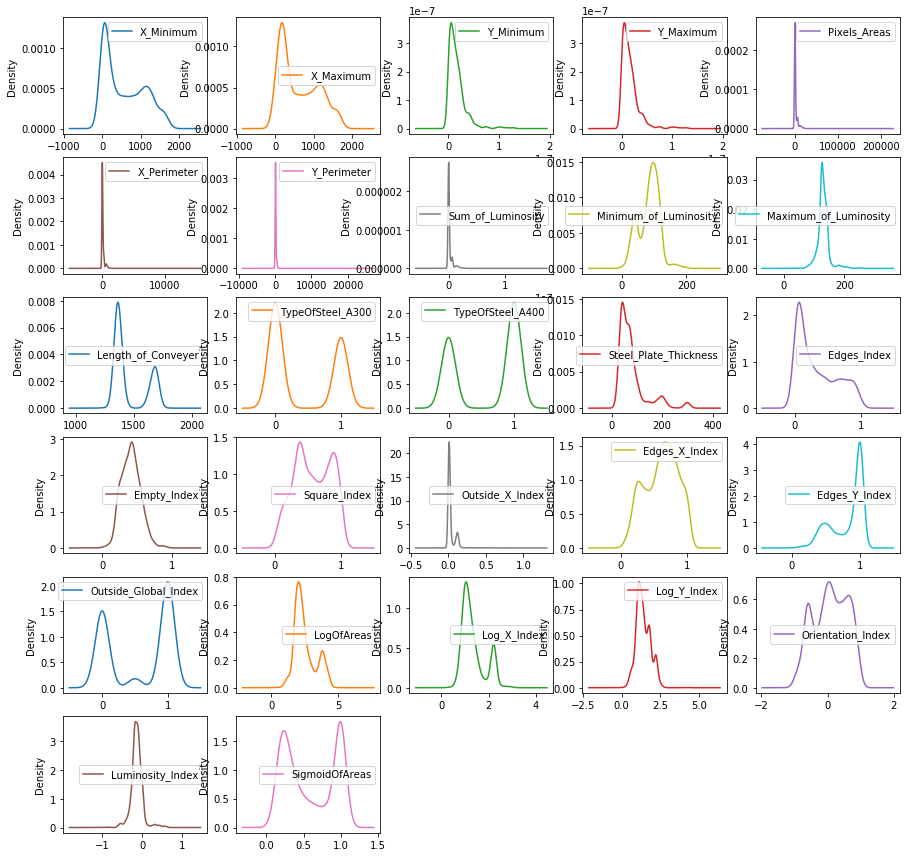

In [19]:
dataset.plot(kind="density", layout=(6,5), 
             subplots=True,sharex=False, sharey=False, figsize=(15,15))
plt.show()

Yukarıdaki yoğunluk grafiklerinde dağılım türü histogram grafiklerinden daha açık görülebilmektedir. Özellikle bimodal dağılımlar daha açık görülüyor.

##### Box Plot(Kutu Çizim) Grafiği

Kutu grafiği tek değişken dağılımı için kullanılabilecek diğer bir grafik türüdür. Kutu grafiği, her bir özelliğin istatiksel dağılımını özetler, medyan (orta değer) için bir çizgi çizer ve 25 ve 75. persentillerin arasındaki değerleri kutuyle temsil eder(verilerin% 50'si). Kutunun alt ve üstünden çizilen T çizimleriyle(Bıyık olarak adlandırılır), verilerin yayılması hakkında fikir verir ve bıyıkların dışındaki noktalar aykırı değerleri gösterir (verilerin% 50'sinin yayılma boyutundan 1.5 kat daha büyük değerler aykırı değer olarak kabul edilir).

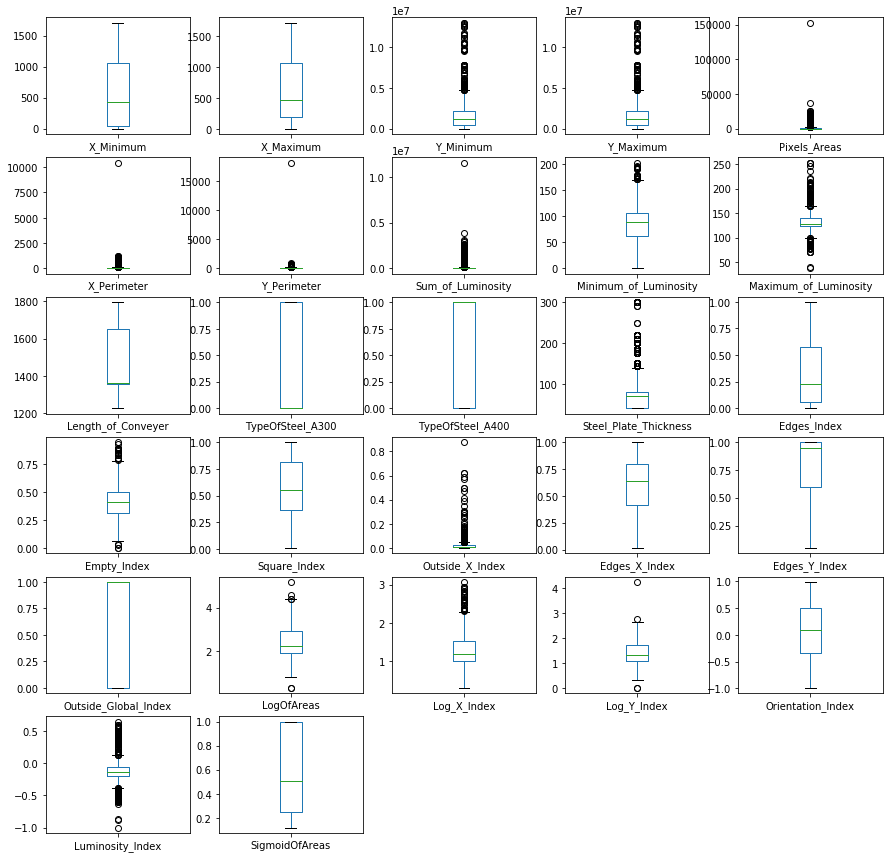

In [20]:
dataset.plot(kind='box', layout=(6,5), 
             subplots=True,sharex=False, sharey=False, figsize=(15,15) )
plt.show()

Yukarıdaki kutu grafiklerinde Y_Minimum, Y_Maximimum, Maximum_Luminosity, vb. özelliklerinde aykırı değerler açıkca görülüyor.

### İki Değişken Dağılımı Grafikler
Hedef değişkenle özelliklerin arasındaki dağılıma bakarak makine öğrenmesi modeline yaptıkları katkıları yorumlayabiliriz.

In [21]:
#Sınıflar ile özelliklerin ikilişkisini gösteren farklı grafikler;
#boxplot, violinplot, pointplot, barplot
def draw_bivariate_plot(dataset, rows, cols, plot_type):
    column_names=dataset.columns.values
    number_of_column=len(column_names)
    fig, axarr=plt.subplots(rows,cols, figsize=(22,16))

    counter=0
    for i in range(rows):
        for j in range(cols):
            if column_names[counter]=='target':
                break
            if 'violin' in plot_type:
                sns.violinplot(x='target', y=column_names[counter],data=dataset, ax=axarr[i][j])
            elif 'box'in plot_type :
                sns.boxplot(x='target', y=column_names[counter],data=dataset, ax=axarr[i][j])
            elif 'point' in plot_type:
                sns.pointplot(x='target',y=column_names[counter],data=dataset, ax=axarr[i][j])
            elif 'bar' in plot_type:
                sns.barplot(x='target',y=column_names[counter],data=dataset, ax=axarr[i][j])
                
            counter+=1
            if counter==(number_of_column-1,):
                break

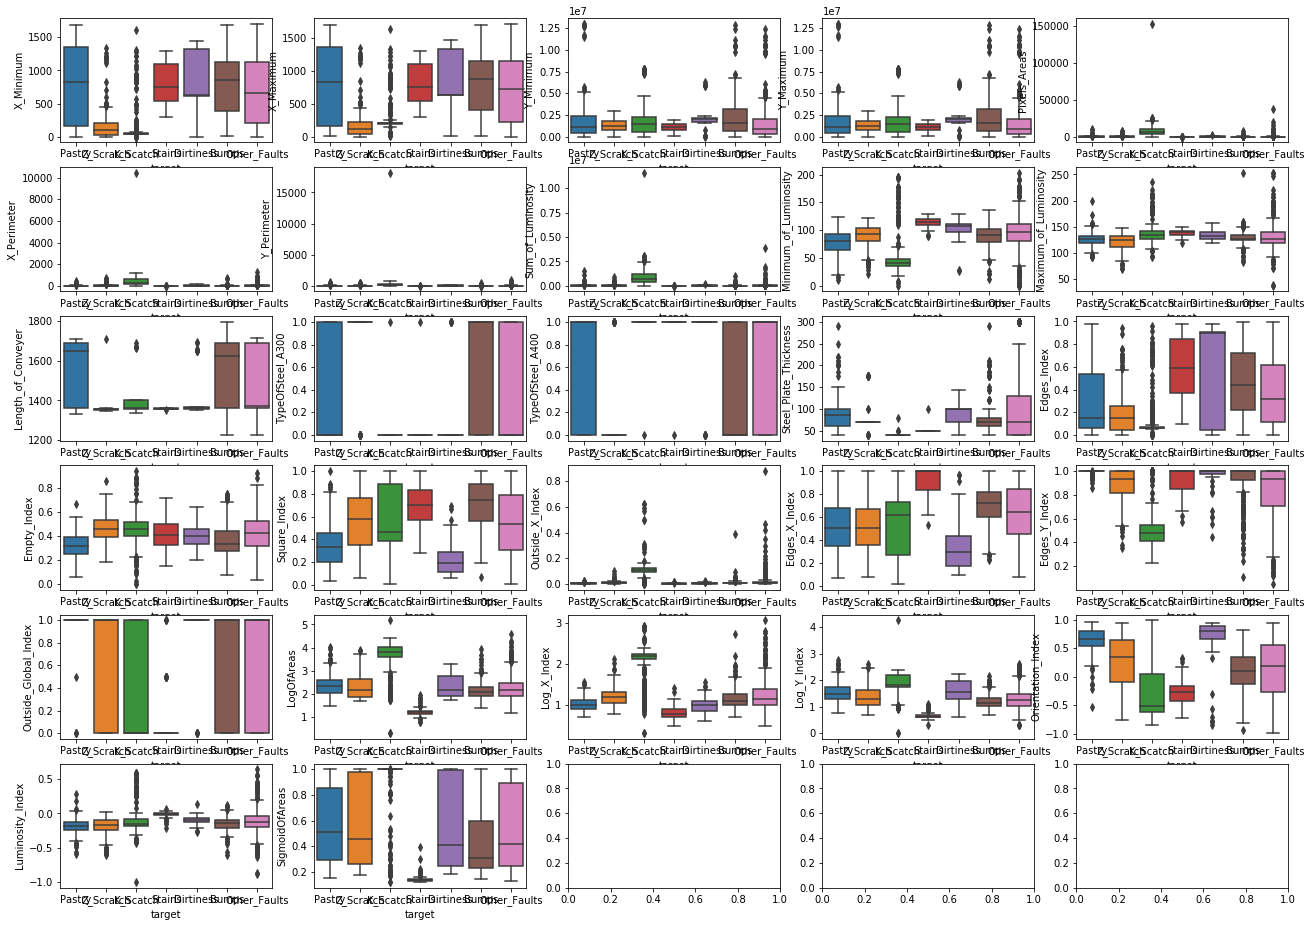

In [22]:
draw_bivariate_plot(dataset=dataset, rows=6, cols=5,plot_type="box") # yukarıda olusturulan fonk. çağrılıyor

Yukarıdaki grafik yer darlığından dolayı sıkışık görünüyor. En iyi özellikleri seçip tekrardan görselleştirelim.

In [23]:
#ilgili kutuphaneler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import LabelEncoder

In [24]:
le=LabelEncoder()
X=dataset.drop('target',axis=1)
Y=le.fit_transform(dataset['target'])

In [25]:
kbest=SelectKBest(score_func=f_classif, k=6)
kbest.fit(X,Y)

SelectKBest(k=6, score_func=<function f_classif at 0x0000018FBCCD38C8>)

In [26]:
k_best=kbest.get_support(indices=True)
feature_names=dataset.columns.values
k_best_feature_names=feature_names[k_best]
k_best_feature_names =np.append(k_best_feature_names,"target")

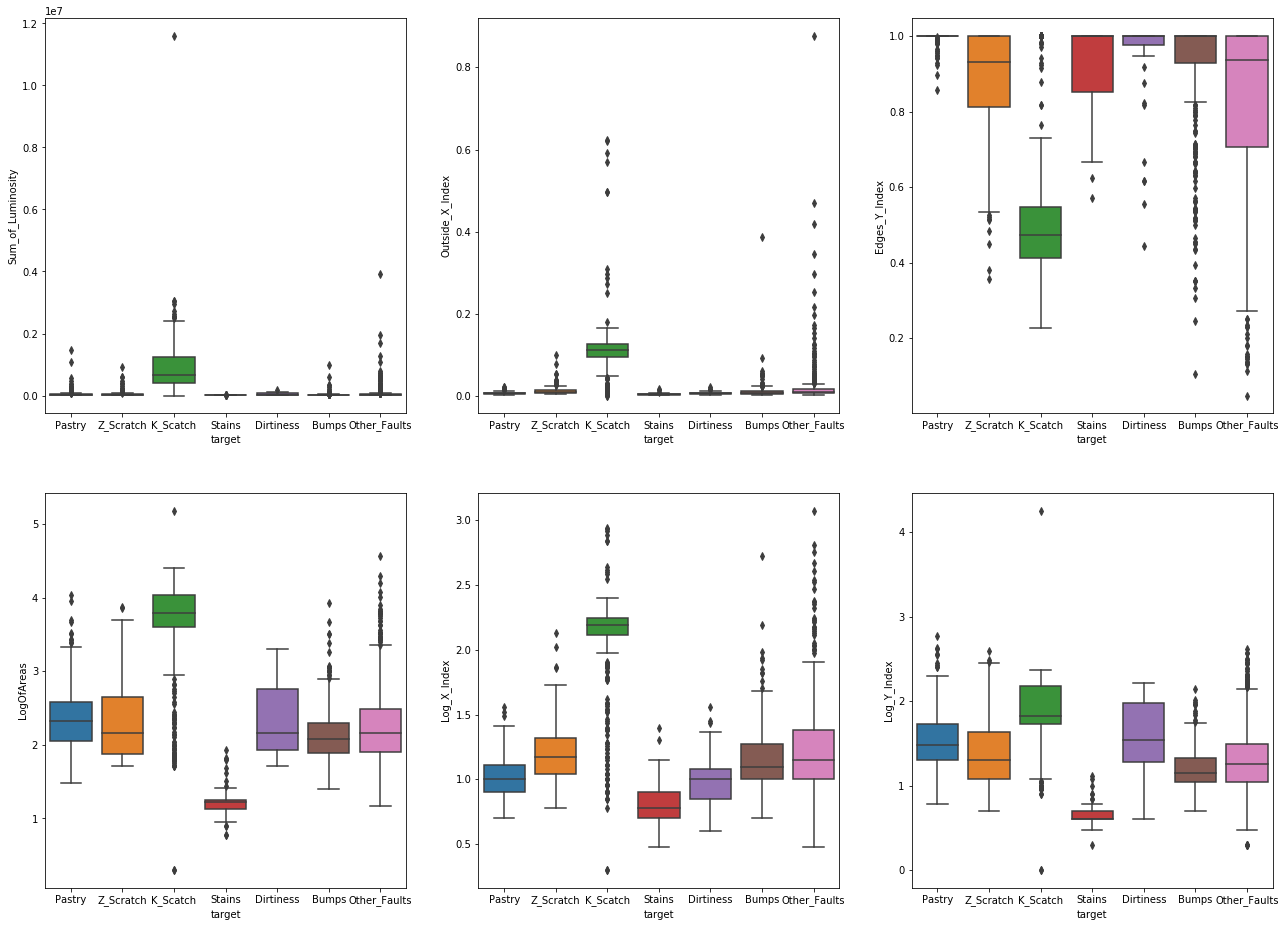

In [27]:
draw_bivariate_plot(dataset=dataset[k_best_feature_names], 
                    rows=2, cols=3,plot_type="box")

# Yardımcı Fonksiyonlar
draw_confusion_matrix fonksiyonu karışıklık matrisini çizdirmek için kullanılacaktır

MyGridSearch fonksiyonu sınıflandırıcıların en iyi sonuç veren parametrelerini bulmak için kullanılacaktır

In [28]:
#Karışıklık matrisisinin çizimi
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d") 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [29]:
def get_train_test(dataset):
    #Kullanılan veri seti makine öğrenmesi modeli için uygun hale getiriliyor
    #x: bağımsız değişkenler
    #y: bağımlı değişken
    X=dataset.drop('target', axis=1)
    y=dataset['target']
    
    #Veri setindeki özellikler farklı değer aralıklarına sahip olduğu için
    #ölçeklendirmenin yapılması gerekir
    standardScaler=StandardScaler()
    X=standardScaler.fit_transform(X)
    
    #Veri seti eğitim ve test bölümlerine ayrıştırılıyor
    #Eğitim veri seti kullanılarak model eğitilecek
    #Test veri setinde eğitilen veri seti test edilecektir
    X_train,X_test,y_train,y_test = train_test_split(X,#veri matrisi
                                                     y, #çıktı sütün vektörü
                                                     stratify=y,#Sınıf oranları dikkate alnıyor
                                                     test_size = 0.3,#%70 eğitim, %30 test
                                                     random_state = 42)
    return X_train,X_test,y_train,y_test

In [30]:
def MyGridSearch(clf, param_grid, dataset):
    
    print("Sınıflandırıcı:",clf.__class__.__name__)
    
    #Eğitim ve test bölümleri alınıyor
    X_train,X_test,y_train,y_test=get_train_test(dataset)
    
    #GridSearchCV ile çapraz doğrulama yapılır
    #Eğitim veri seti beş(cv=5) parçaya ayrılarak her birisi için başarı oranları elde edilir.
    grid_search=GridSearchCV(clf, param_grid, cv=5)
    
    #Beş ayrı bölüme ayrılan eğitim setinin her birisi için eğitim gerçekleştirilir
    grid_search.fit(X_train, y_train)

    #Bel ayrı başarı oranından en iyisine göre test veri setinin sonucu elde edilir.
    accuracy=grid_search.score(X_test,y_test)
    
    #Test başarı oranı yazdırılıy
    print("Başarı oranı:",accuracy)
    #Test için kullanılan parametreler yazdırılıyor
    print("grid_search.best_params_:",grid_search.best_params_)
    
    #Karışıklık matrisi ve sınıflandırma raporu için tüm test verisine ait
    #tahminler yapılıyor
    y_pred=grid_search.predict(X_test)
    
    cm = confusion_matrix(y_test,y_pred)
    draw_confusion_matrix(cm)
    print('Sınıflandırma Raporu: \n',classification_report(y_test,y_pred))

# SVC Sonuçları

In [31]:
svc_param_grid={'C':[0.001,0.01,0.1, 1, 10, 100],
           'gamma':[0.001,0.01,0.1, 1, 10, 100],
               'kernel':['linear', 'rbf']}
#Bu işlem bir kaç dakika kadar sürebiliyor. İsterseniz çalışmayı çatallayıp(Fork) deneyebilirsiniz.
#Elde edilen en iyi parametreler; {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
#MyGridSearch(SVC(), svc_param_grid, dataset )

Sınıflandırıcı: SVC
Başarı oranı: 0.7598627787307033
grid_search.best_params_: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


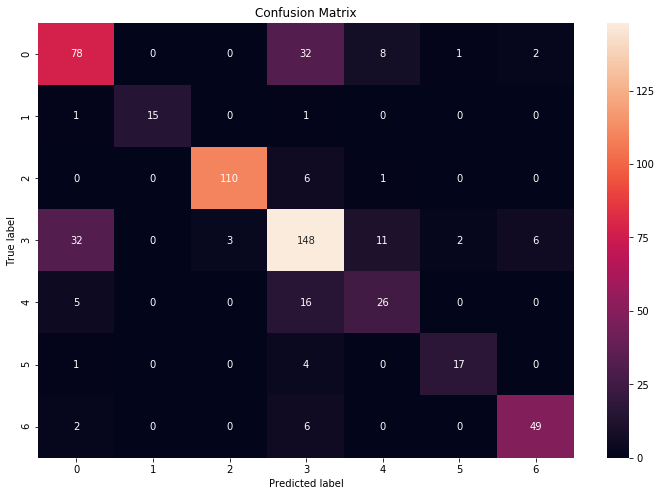

Sınıflandırma Raporu: 
               precision    recall  f1-score   support

       Bumps       0.66      0.64      0.65       121
   Dirtiness       1.00      0.88      0.94        17
    K_Scatch       0.97      0.94      0.96       117
Other_Faults       0.69      0.73      0.71       202
      Pastry       0.57      0.55      0.56        47
      Stains       0.85      0.77      0.81        22
   Z_Scratch       0.86      0.86      0.86        57

    accuracy                           0.76       583
   macro avg       0.80      0.77      0.78       583
weighted avg       0.76      0.76      0.76       583



In [32]:
svc_best_params={'C':[ 10],
           'gamma':[0.1],
            'kernel':['rbf']}
MyGridSearch(SVC(), svc_best_params, dataset )

# RandomForestClassifier Sonuçları

In [33]:
random_forest_param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
#Bu işlem beş dakika kadar sürebiliyor.
#Elde edilen en iyi parametreler; 
# {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
#MyGridSearch(RandomForestClassifier(n_estimators=48), random_forest_param_grid, dataset )

Sınıflandırıcı: RandomForestClassifier
Başarı oranı: 0.7873070325900514
grid_search.best_params_: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 48}


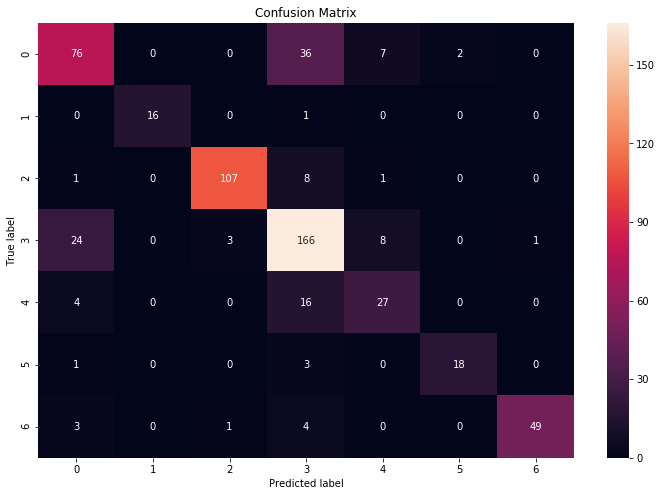

Sınıflandırma Raporu: 
               precision    recall  f1-score   support

       Bumps       0.70      0.63      0.66       121
   Dirtiness       1.00      0.94      0.97        17
    K_Scatch       0.96      0.91      0.94       117
Other_Faults       0.71      0.82      0.76       202
      Pastry       0.63      0.57      0.60        47
      Stains       0.90      0.82      0.86        22
   Z_Scratch       0.98      0.86      0.92        57

    accuracy                           0.79       583
   macro avg       0.84      0.79      0.81       583
weighted avg       0.79      0.79      0.79       583



In [34]:
rfc_best_params={'n_estimators':[48],
    'bootstrap': [False], 
             'criterion': ['entropy'], 
             'max_depth': [None], 
             'max_features': [10], 
             'min_samples_leaf': [1], 
             'min_samples_split': [2]}
MyGridSearch(RandomForestClassifier(), rfc_best_params, dataset )

# Denetimsiz Öğrenmeyle Boyut Azaltma: Temel Bileşen Analizi

In [35]:
from sklearn.decomposition import PCA

In [36]:
X_train,X_test,y_train,y_test=get_train_test(dataset)

In [37]:
pca=PCA(whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

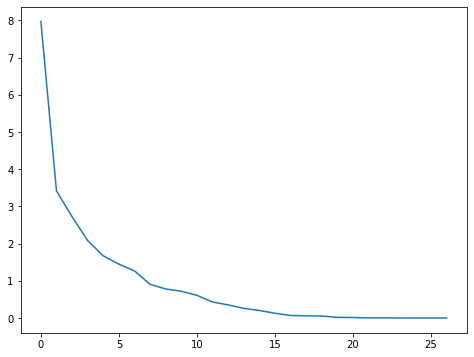

In [38]:
plt.figure(figsize=(8,6))
plt.plot(pca.explained_variance_)

Yukarıdaki grafif 15 temel bileşenin özellik verktörünü temsil edebileceğini göstermektedir. 15 temel bileşene göre PCA dönüşümünü yapalım

In [39]:
pca=PCA(n_components=15)
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)
print("PCA dönüşümü gerçekleştirildi")

PCA dönüşümü gerçekleştirildi


In [40]:
clf=SVC()
clf.fit(X_train_pca, y_train)
y_pred=clf.predict(X_test_pca)
print("PCA dönüşümü yapılan veri seti üzerinde tahmin yapıldı")

PCA dönüşümü yapılan veri seti üzerinde tahmin yapıldı


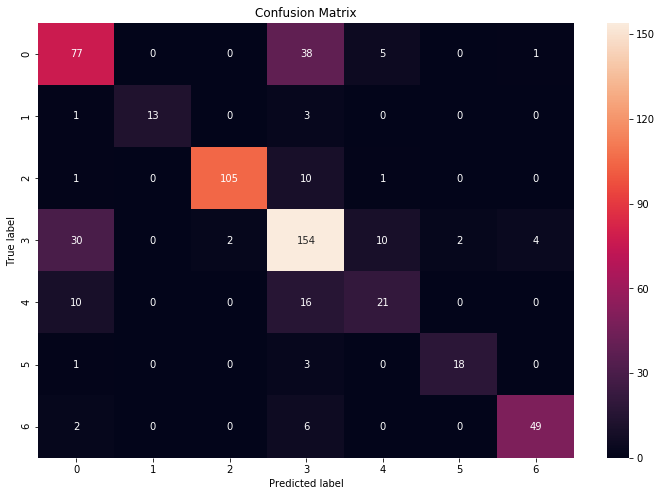

Başarı oranı:0.75
Sınıflandırma Raporu: 
               precision    recall  f1-score   support

       Bumps       0.63      0.64      0.63       121
   Dirtiness       1.00      0.76      0.87        17
    K_Scatch       0.98      0.90      0.94       117
Other_Faults       0.67      0.76      0.71       202
      Pastry       0.57      0.45      0.50        47
      Stains       0.90      0.82      0.86        22
   Z_Scratch       0.91      0.86      0.88        57

    accuracy                           0.75       583
   macro avg       0.81      0.74      0.77       583
weighted avg       0.76      0.75      0.75       583



In [47]:
cm = confusion_matrix(y_test,y_pred)
draw_confusion_matrix(cm)
print("Başarı oranı:{:.2f}".format(clf.score(X_test_pca,y_test)))
print('Sınıflandırma Raporu: \n',classification_report(y_test,y_pred))